In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from scipy.stats import shapiro, probplot, mannwhitneyu, chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import pickle
import warnings
warnings.simplefilter('ignore')

# matplotlib.use('Agg')
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', None)

# 1 read data

In [64]:
df_train = pd.read_csv('../datasets/course_project_train.csv')
df_test = pd.read_csv('../datasets/course_project_test.csv')

# Overview of datasets

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [34]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [35]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Lists columns for target, category and number

In [3]:
TARGET_COLUMN = 'Credit Default'
CATEGORY_COLUMNS = df_train.select_dtypes(include='category').columns.tolist()
INTEGER_FLOAT_COLUMNS = df_train.drop(CATEGORY_COLUMNS, axis=1).drop(TARGET_COLUMN, axis=1).columns.tolist()

In [37]:
corr_matrix = df_train.corr().iloc[:-1, -1].sort_values()
corr_matrix

Current Loan Amount            -0.226522
Annual Income                  -0.101375
Years of Credit History        -0.020567
Current Credit Balance         -0.019522
Maximum Open Credit            -0.014275
Bankruptcies                    0.001648
Months since last delinquent    0.002598
Monthly Debt                    0.018480
Number of Credit Problems       0.020088
Tax Liens                       0.024368
Number of Open Accounts         0.028884
Credit Score                    0.442050
Name: Credit Default, dtype: float64

<AxesSubplot:>

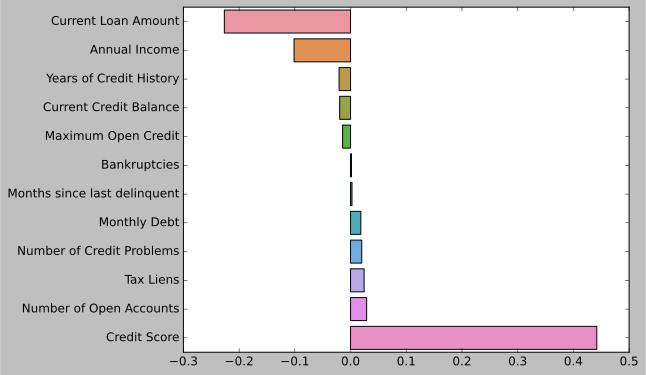

In [38]:
sns.barplot(corr_matrix.values, corr_matrix.index)

# 2 Preprocessing data to outlier and null

Text(0.5, 1.0, 'Annual Income')

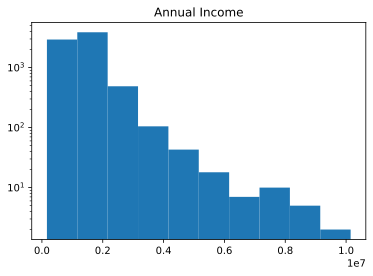

In [11]:
plt.hist(df_train['Annual Income'])
plt.yscale(value='log')
plt.title('Annual Income')

In [13]:
shapiro(df_train['Annual Income'])

ShapiroResult(statistic=0.7313876152038574, pvalue=0.0)

<AxesSubplot:xlabel='Annual Income'>

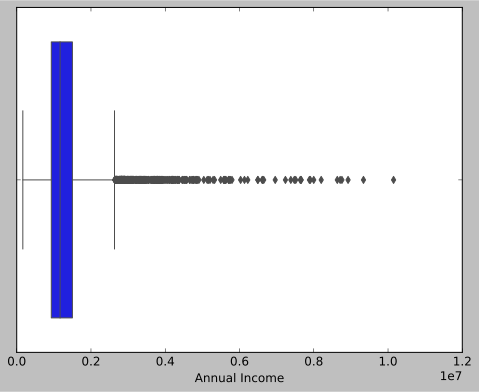

In [25]:
plt.style.use('classic')
sns.boxplot(df_train['Annual Income'], whis=2)

### I replace outlier:
big number for median
small number for mean
NaN for median or mean

In [66]:
class PreprocessingDataNaN:

    def __init__(self, df_tr):
        self.data_median = df_tr.median()
        self.data_mean = df_tr.mean()

    def data_none(self, df, name_column, method='median'):
        assert method in ['median', 'mean'], 'You entered wrong method name, this must have: [median, mean]'

        if not self.df_have_column_with_outlier(df, f'{name_column}_outlier'):
            self.create_label_for_none(df, name_column)
        else:
            self.add_label_in_column_outlier(df, name_column)

        if method == 'median':
            df.loc[df[name_column].isna(), f'{name_column}'] = self.data_median[name_column]
        else:
            df.loc[df[name_column].isna(), f'{name_column}'] = self.data_mean[name_column]

    def create_label_for_none(self, df, name_column):
        df[f'{name_column}_outlier'] = 0
        df.loc[df[name_column].isnull(), f'{name_column}_outlier'] = 1

    def add_label_in_column_outlier(self, df, name_column):
        df.loc[df[name_column].isnull(), f'{name_column}_outlier'] = 1

    def df_have_column_with_outlier(self, df, name_column_outlier):
        return name_column_outlier in df.columns

# my_class_for_none = PreprocessingDataNaN(df_train)

In [67]:
class PreprocessingDataMaxMin(PreprocessingDataNaN):

    def data_max_min_with_outlier(self, df, name_column, param_column, max_or_min='max', method_replace='median'):
        assert max_or_min in ('max', 'min'), 'You entered wrong max_or_min, this must have: [max, min]'

        if max_or_min == 'max':
            df.loc[df[name_column] > param_column, name_column] = np.NAN
        else:
            df.loc[df[name_column] < param_column, name_column] = np.NAN

        self.data_none(df, name_column, method_replace)

    def data_max_min(self,  df, name_column, param_column, max_or_min='max', replace_method='median'):
        assert max_or_min in ('max', 'min'), 'You entered wrong max_or_min, this must have: [max, min]'
        assert replace_method in ('median', 'mean'), 'You entered wrong replace_method, this must have: [median, min]'

        if replace_method == 'median' and max_or_min == 'max':
            self.replace_max_for_median(df, name_column, param_column)

        elif replace_method == 'median' and max_or_min == 'min':
            self.replace_min_for_median(df, name_column, param_column)

        elif replace_method == 'mean' and max_or_min == 'max':
            self.replace_max_for_mean(df, name_column, param_column)

        elif replace_method == 'mean' and max_or_min == 'min':
            self.replace_min_for_mean(df, name_column, param_column)

    def replace_max_for_median(self, df, name_column, param_column):
        df.loc[df[name_column] > param_column, name_column] = self.data_median[name_column]

    def replace_min_for_median(self, df, name_column, param_column):
        df.loc[df[name_column] < param_column, name_column] = self.data_median[name_column]

    def replace_max_for_mean(self, df, name_column, param_column):
        df.loc[df[name_column] > param_column, name_column] = self.data_mean[name_column]

    def replace_min_for_mean(self, df, name_column, param_column):
        df.loc[df[name_column] < param_column, name_column] = self.data_mean[name_column]


<AxesSubplot:xlabel='Credit Score', ylabel='Density'>

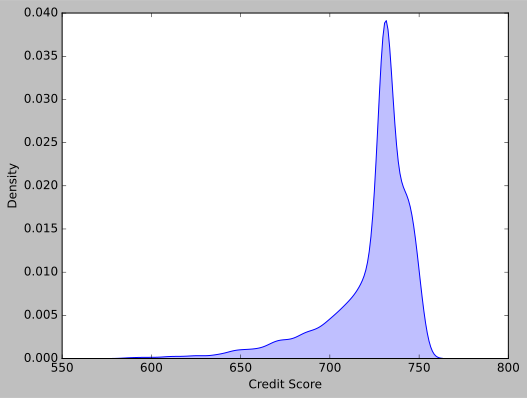

In [92]:
sns.kdeplot(df_train['Credit Score'], shade=True, color='b')

In [68]:
class_for_none_and_max_min = PreprocessingDataMaxMin(df_train)
class_for_none_and_max_min.data_max_min_with_outlier(df_train, 'Annual Income', (6*10**6))
class_for_none_and_max_min.data_max_min_with_outlier(df_train, 'Credit Score', (2*10**3))
class_for_none_and_max_min.data_none(df_train, 'Bankruptcies')


### it is now i result my work with test

In [69]:
class_for_none_and_max_min.data_max_min_with_outlier(df_test, 'Annual Income', (6*10**6))
class_for_none_and_max_min.data_max_min_with_outlier(df_test, 'Credit Score', (2*10**3))
class_for_none_and_max_min.data_none(df_test, 'Bankruptcies')

### Column Current Loan Amount

In [ ]:
df_train['Current Loan Amount'].sort_values()

In [ ]:
sns.kdeplot(x=df_train['Current Loan Amount'], shade=True)

In [ ]:
temporary_df = df_train.loc[df_train['Current Loan Amount'] < (4 * 10**7)]
sns.pointplot(x=TARGET_COLUMN, y='Current Loan Amount', data=temporary_df)

In [ ]:
df_train.loc[df_train['Current Loan Amount'] > (10**6), 'Current Loan Amount'].count()

In [ ]:
sns.boxplot(df_train['Current Loan Amount'])
plt.xscale(value='log')

I change outlier to median for column Current Loan Amount

In [ ]:
class_for_none_and_max_min.data_max_min(df_train, 'Current Loan Amount', (10**6))
class_for_none_and_max_min.data_max_min(df_train, 'Current Loan Amount', (10**6))

### work with column Maximum Open Credit

In [ ]:
df_train['Maximum Open Credit'].sort_values()

In [ ]:
sns.kdeplot(df_train['Maximum Open Credit'], shade=True, color='r', )
plt.yscale(value='log')

In [ ]:
sns.pointplot(x=TARGET_COLUMN, y='Maximum Open Credit', data=df_train, capsize=.2)

In [ ]:
sns.boxplot(df_train['Maximum Open Credit'])
plt.xscale(value='log')

I'm processing the column Maximum open credit per outlier to mean because
because this is best by my mind

In [ ]:
 # (2 *  10**8)

class_for_none_and_max_min.data_max_min_with_outlier(df_train, 'Maximum Open Credit', (2 * 10**8), method_replace='mean')
class_for_none_and_max_min.data_max_min_with_outlier(df_test, 'Maximum Open Credit', (2 * 10**8), method_replace='mean')

# 3 EDA and cleaning for data

### Column years in current job is category and have NaN

In [114]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

<AxesSubplot:xlabel='count', ylabel='Years in current job'>

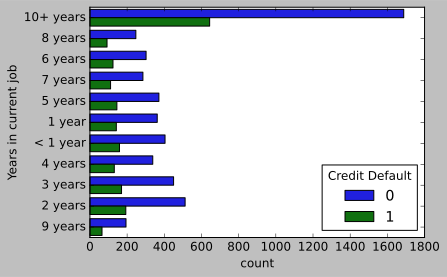

In [118]:
plt.figure(figsize=(6, 4))
sns.countplot(y='Years in current job', hue=TARGET_COLUMN, data=df_train)

In [70]:
df_train['Id'] = df_train.index
table_pivot = df_train.pivot_table(
    values='Id',
    index='Years in current job',
    columns=TARGET_COLUMN,
    aggfunc='count')

chi2, p, *args = chi2_contingency(table_pivot.drop(index=['10+ years']))
df_train.drop(columns='Id', inplace=True)
p

0.9962062438103243

In [147]:
df_train.loc[df_train['Years in current job'].isna(), TARGET_COLUMN].value_counts()

0    234
1    137
Name: Credit Default, dtype: int64

i drop column Years in current job because he is haven't correletion for target column

In [71]:


class DropColumn:

    __slots__ = ('column_name', 'df')

    def __init__(self, df, column_name):
        self.df = df.copy()
        self.column_name = column_name

    @property
    def drop_column(self):
        return self.df.drop(columns=self.column_name)


class_for_drop = DropColumn(df_train, 'Years in current job')
df_train = class_for_drop.drop_column
class_for_drop = DropColumn(df_test, 'Years in current job')
df_test = class_for_drop.drop_column

In [ ]:
CATEGORY_COLUMNS.remove('Years in current job')

In [77]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Tax Liens                     7500 non-null   float64
 3   Number of Open Accounts       7500 non-null   float64
 4   Years of Credit History       7500 non-null   float64
 5   Maximum Open Credit           7500 non-null   float64
 6   Number of Credit Problems     7500 non-null   float64
 7   Months since last delinquent  7500 non-null   float64
 8   Bankruptcies                  7500 non-null   float64
 9   Purpose                       7500 non-null   object 
 10  Term                          7500 non-null   object 
 11  Current Loan Amount           7500 non-null   float64
 12  Current Credit Balance        7500 non-null   float64
 13  Mon

# I go back to step 2 and process the column Months since last late payment
### i use model for filling NaN in column Months since last delinquent

In [76]:
from sklearn.neighbors import KNeighborsRegressor


class ModelForNone:

    def __init__(self, model_fit, df, target_column):
        self.model_neighbor = model_fit
        train_target_column = df.loc[~df[target_column].isnull(), target_column]
        train_df = df.loc[~df[target_column].isnull()].drop(columns=target_column)
        self.model_neighbor.fit(train_df, train_target_column)
        self.target_column = target_column

    def model_filling(self, df):
        result_predict = self.model_neighbor.predict(self.valid_df_for_predict(df))
        return result_predict

    def valid_df_for_predict(self, df):
        valid_df = df.loc[df[self.target_column].isnull()].drop(columns=self.target_column)
        return valid_df


train = df_train.drop(columns=CATEGORY_COLUMNS+[TARGET_COLUMN])
class_for_filling_none = ModelForNone(KNeighborsRegressor(), train, 'Months since last delinquent')
target_valid = class_for_filling_none.model_filling(train)
df_train.loc[df_train['Months since last delinquent'].isna(), 'Months since last delinquent'] = target_valid

test = df_test.drop(columns=CATEGORY_COLUMNS)
target_test = class_for_filling_none.model_filling(test)
df_test.loc[df_test['Months since last delinquent'].isna(), 'Months since last delinquent'] = target_test

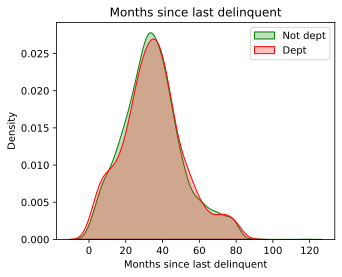

In [40]:
months_since_last_0 = df_train.loc[df_train[TARGET_COLUMN] == 0, 'Months since last delinquent']
months_since_last_1 = df_train.loc[df_train[TARGET_COLUMN] == 1, 'Months since last delinquent']

plt.figure(figsize=(5, 4))
sns.kdeplot(months_since_last_0, label='Not dept', color='g', shade=True)
sns.kdeplot(months_since_last_1, label='Dept', color='r', shade=True)

plt.title('Months since last delinquent')
plt.legend()

((array([-3.73889526, -3.50968086, -3.3836472 , ...,  3.3836472 ,
          3.50968086,  3.73889526]),
  array([  0.,   0.,   0., ...,  91.,  92., 118.])),
 (16.3031306789844, 34.91168, 0.9910598312149295))

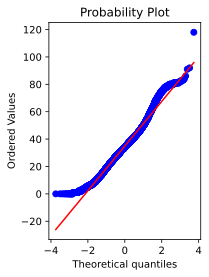

In [45]:
plt.subplot(122)
probplot(df_train['Months since last delinquent'], dist='norm', plot=plt)

<AxesSubplot:xlabel='Months since last delinquent'>

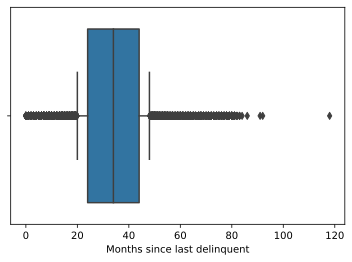

In [78]:
sns.boxplot(df_train['Months since last delinquent'], whis=.2)


In [79]:
class_for_none_and_max_min.data_max_min(df_train, name_column='Months since last delinquent', param_column=90, replace_method='mean')
class_for_none_and_max_min.data_max_min(df_test, name_column='Months since last delinquent', param_column=90, replace_method='mean')

### I return to step 3
# 3 EDA and clean data

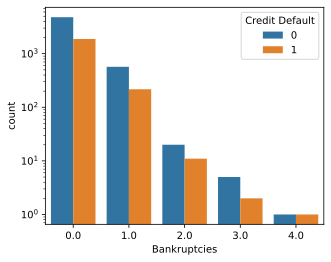

In [80]:
plt.figure(figsize=(5, 4))
sns.countplot(x='Bankruptcies', hue=TARGET_COLUMN, data=df_train)
plt.yscale(value='log')

In [81]:
df_train['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

I want to know if the frequencies of the values in
the Bankruptcies column for the target feature are the same

In [99]:
def pivot_table(df, index_column, target_column):
    df_temporary = df.copy()
    df_temporary['Id'] = df.index
    return df_temporary.pivot_table(
        values='Id',
        index=index_column,
        columns=target_column,
        aggfunc='count'
    )

temporary_pivot = pivot_table(df_train, 'Bankruptcies', TARGET_COLUMN)
chi2_0_1, p_0_1, *args_0_1 = chi2_contingency(temporary_pivot[0:1])
chi2_2_3, p_2_3, *args_2_3 = chi2_contingency(temporary_pivot.drop(index=[2, 1, 4]))
print(p_0_1, p_2_3, sep='\n')

0.7592266602852901
1.0


I combine the values of the Tax Liens column with the same frequencies

In [100]:
df_train.replace({'Bankruptcies': {1: 0, 3: 1, 2: 1, 4: 2}}, inplace=True)
df_test.replace({'Bankruptcies': {1: 0, 3: 1, 2: 1, 4: 2}}, inplace=True)

In [2]:
def save_progress():
    df_train.to_pickle('df_train.pkl')
    df_test.to_pickle('df_test.pkl')

def read_df_pickle():
    df_train = pd.read_pickle('df_train.pkl')
    df_test = pd.read_pickle('df_test.pkl')
    return df_train, df_test

### Work with column Tax liens

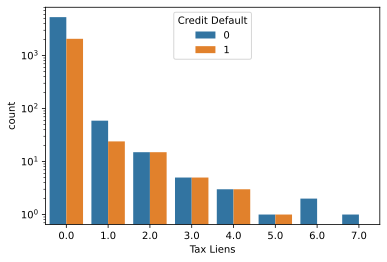

In [104]:
sns.countplot(x='Tax Liens', hue=TARGET_COLUMN, data=df_train)
plt.yscale(value='log')

In [119]:
table_pivot_tax_liens = pivot_table(df_train, 'Tax Liens', TARGET_COLUMN)
table_pivot_tax_liens

Credit Default,0,1
Tax Liens,,
0.0,5301.0,2065.0
1.0,59.0,24.0
2.0,15.0,15.0
3.0,5.0,5.0
4.0,3.0,3.0
5.0,1.0,1.0
6.0,2.0,NaN
7.0,1.0,NaN


In [121]:
chi2_25, p_val_25, *args_25 = chi2_contingency(table_pivot_tax_liens[2:5])
chi2_01, p_val_01, *args_01 = chi2_contingency(table_pivot_tax_liens[0:1])
print(f'{p_val_01} - 0 to 2', f'{p_val_25} - 2 to 5', sep='\n')

0.956212700856196 0 to 2
1.0 2 to 5


I combine the values of the Tax Liens column with the same frequencies

In [122]:
def change_tax_liens(df):
    df.loc[df['Tax Liens'].isin([0, 1]), 'Tax Liens'] = 0
    df.loc[df['Tax Liens'].isin([2, 3, 4, 5]), 'Tax Liens'] = 1
    df.loc[df['Tax Liens'].isin([6, 7]), 'Tax Liens'] = 2

change_tax_liens(df_train)
change_tax_liens(df_test)

In [ ]:
df_train.describe()

In [123]:
save_progress()

### Column Number of Credit Problems

In [135]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_outlier,Credit Score_outlier,Bankruptcies_outlier,Maximum Open Credit_outlier
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.00000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.303031e+06,0.007200,11.130933,18.317467,6.854929e+05,0.170000,34.885424,0.00560,1.187318e+07,2.898332e+05,18314.454133,723.392000,0.281733,0.211067,0.260933,0.001867,0.000400
std,6.576812e+05,0.089158,4.908924,7.041946,1.263487e+06,0.498598,16.389595,0.07812,3.192612e+07,3.178714e+05,11926.764673,24.196917,0.449874,0.408093,0.439173,0.043167,0.019997
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.00000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.311330e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,24.000000,0.00000,1.801690e+05,1.142565e+05,10067.500000,718.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,34.000000,0.00000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.492792e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,44.000000,0.00000,5.198820e+05,3.604062e+05,23818.000000,738.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,5.798040e+06,2.000000,43.000000,57.700000,5.756256e+07,7.000000,86.000000,2.00000,1.000000e+08,6.506797e+06,136679.000000,751.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [136]:
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

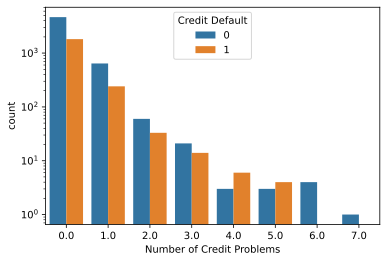

In [137]:
sns.countplot(x='Number of Credit Problems', hue=TARGET_COLUMN, data=df_train)
plt.yscale(value='log')

In [139]:
table_pivot_number_credit_problems = pivot_table(df_train, 'Number of Credit Problems', TARGET_COLUMN)
table_pivot_number_credit_problems

Credit Default,0,1
Number of Credit Problems,,
0.0,4654.0,1815.0
1.0,641.0,241.0
2.0,60.0,33.0
3.0,21.0,14.0
4.0,3.0,6.0
5.0,3.0,4.0
6.0,4.0,NaN
7.0,1.0,NaN


In [144]:
chi2, p_val, *args = chi2_contingency(table_pivot_number_credit_problems[0:1])
p_val

0.6783214582441461

I combine the values of the Number of Credit Problems column with the same frequencies

In [145]:
def preprocessing_number_credit_problems(df):
    df.loc[df['Number of Credit Problems'].isin([0, 1, 2, 3]), 'Number of Credit Problems'] = 0
    df.loc[df['Number of Credit Problems'].isin([4, 5]), 'Number of Credit Problems'] = 1
    df.loc[df['Number of Credit Problems'].isin([6, 7]), 'Number of Credit Problems'] = 2


preprocessing_number_credit_problems(df_train)
preprocessing_number_credit_problems(df_test)

In [161]:
save_progress()

### Work with category columns

In [163]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Tax Liens                     7500 non-null   float64
 3   Number of Open Accounts       7500 non-null   float64
 4   Years of Credit History       7500 non-null   float64
 5   Maximum Open Credit           7500 non-null   float64
 6   Number of Credit Problems     7500 non-null   float64
 7   Months since last delinquent  7500 non-null   float64
 8   Bankruptcies                  7500 non-null   float64
 9   Purpose                       7500 non-null   object 
 10  Term                          7500 non-null   object 
 11  Current Loan Amount           7500 non-null   float64
 12  Current Credit Balance        7500 non-null   float64
 13  Mon

In [178]:
for name in df_train['Home Ownership'].unique():
    print(f'\t\t{name}')
    print(df_train.loc[df_train['Home Ownership'] == f'{name}', TARGET_COLUMN].value_counts())

		Own Home
0    455
1    192
Name: Credit Default, dtype: int64
		Home Mortgage
0    2721
1     916
Name: Credit Default, dtype: int64
		Rent
0    2201
1    1003
Name: Credit Default, dtype: int64
		Have Mortgage
0    10
1     2
Name: Credit Default, dtype: int64


I change the string type to categorical by replacing with a
number that is equal to the number of feature values

In [187]:
class FeatureValueCounts:

    __slots__ = ('df', 'column_name', 'dict_value_counts')

    def __init__(self, df, column_name):
        self.dict_value_counts = df[column_name].value_counts()
        self.column_name = column_name

    def replace_to_value_counts(self, df):
        df[self.column_name] = df[self.column_name].replace(self.dict_value_counts)
        df[self.column_name] = df[self.column_name].astype('category')


create_feature_and_replace_category = FeatureValueCounts(df_train, 'Home Ownership')
create_feature_and_replace_category.replace_to_value_counts(df_train)
create_feature_and_replace_category.replace_to_value_counts(df_test)

In [183]:
save_progress()

In [184]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

For column Purpose i do same that i did for column Home Ownership

In [188]:
change_to_value_counts = FeatureValueCounts(df_train, 'Purpose')
change_to_value_counts.replace_to_value_counts(df_train)
change_to_value_counts.replace_to_value_counts(df_test)

In [194]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 7500 non-null   float64 
 2   Tax Liens                     7500 non-null   float64 
 3   Number of Open Accounts       7500 non-null   float64 
 4   Years of Credit History       7500 non-null   float64 
 5   Maximum Open Credit           7500 non-null   float64 
 6   Number of Credit Problems     7500 non-null   float64 
 7   Months since last delinquent  7500 non-null   float64 
 8   Bankruptcies                  7500 non-null   float64 
 9   Purpose                       7500 non-null   category
 10  Term                          7500 non-null   category
 11  Current Loan Amount           7500 non-null   float64 
 12  Current Credit Balance        7500 non-null   fl

<AxesSubplot:xlabel='Term', ylabel='count'>

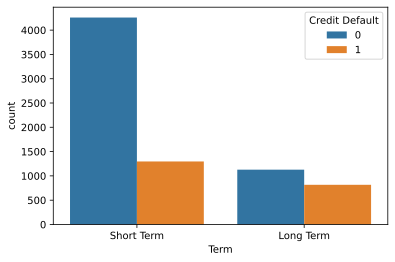

In [191]:
sns.countplot(x='Term', hue=TARGET_COLUMN, data=df_train)

In [192]:
def replace_term(df):
    df.replace({'Term': {'Short Term': 0,
                              'Long Term': 1}}, inplace=True)
    df['Term'] = df['Term'].astype('category')

replace_term(df_train)
replace_term(df_test)

In [196]:
save_progress()

In [ ]:
df_train, df_test = read_df_pickle()

In [208]:
def reduce_memory_df(df):
    start_mem = df.memory_usage().sum() // 1024
    print(f'Memory usage start {start_mem} KB')

    for column in df.columns:
        col_type = df[column].dtype

        if col_type.kind != 'O':
            col_max = df[column].max()
            col_min = df[column].min()

            if col_type.kind == 'i':
                for into_param in [np.int8, np.int16, np.int32]:
                    if col_min > np.iinfo(into_param).min and col_max < np.iinfo(into_param).max:
                        df[column] = df[column].astype(into_param)
            else:
                for float_param in [np.float16, np.float32]:
                    if col_min > np.finfo(float_param).min and col_max < np.finfo(float_param).max:
                        df[column] = df[column].astype(float_param)
        else:
            df[column] = df[column].astype('category')

    end_mem = df.memory_usage().sum() // 1024
    print(f'End memory {end_mem} KB')

reduce_memory_df(df_train)
reduce_memory_df(df_test)

Memory usage start 1019 KB
End memory 521 KB
Memory usage start 320 KB
End memory 164 KB


# 4 Learn models and find best

In [4]:
def get_classification_report(y_train_pred, y_valid_pred, y_train_true, y_valid_true):
    print('TRAIN', classification_report(y_train_true, y_train_pred), sep='\n')
    print('VALID', classification_report(y_valid_true, y_valid_pred), sep='\n')
    print('\t\tCross Matrix', pd.crosstab(y_valid_true, y_valid_pred), sep='\n')

def evaluate_model(model, x_tr, x_val, y_true_tr, y_true_val):
    y_pred_train = model.predict(x_tr)
    y_pred_valid = model.predict(x_val)

    get_classification_report(y_pred_train, y_pred_valid, y_true_tr, y_true_val)

In [5]:
"""
    category_columns - original categories columns name
    number_columns - digit columns name
    number_category_columns - i added categories columns name
"""
import re

category_columns = df_train.select_dtypes(include='category').columns.tolist()
number_columns = df_train.columns.drop(category_columns).tolist()
number_category_columns = list()

for name_col in number_columns:
    column = re.search(r'.+_outlier$', name_col, flags=re.IGNORECASE)
    if column != None:
        number_category_columns.append(column.group())

for column in number_category_columns:
    number_columns.remove(column)

number_columns.remove(TARGET_COLUMN)

### split data

In [6]:
# df_train, df_test = read_df_pickle()

x = df_train[number_columns + number_category_columns + category_columns]
y = df_train[TARGET_COLUMN]

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25,
                                                      random_state=49,
                                                      shuffle=True,
                                                      stratify=y)
print(y_train.value_counts(normalize=True), y_valid.value_counts(normalize=True), sep='\n')

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64
0    0.7184
1    0.2816
Name: Credit Default, dtype: float64


### Data scalern through StandardScaler

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train[number_columns] = scaler.fit_transform(x_train[number_columns])
x_valid[number_columns] = scaler.transform(x_valid[number_columns])

In [214]:
with open('scaler_model.pkl', 'wb') as file:
    pickle.dump(scaler, file)

x_train.to_csv('x_train.csv', index=False, encoding='utf-8')
x_valid.to_csv('x_valid.csv', index=False, encoding='utf-8')

### I search the best model

In [14]:

tree_model = DecisionTreeClassifier(random_state=49,
                                    max_depth=6,
                                    class_weight={0: 1, 1: 2.5}
                                    )

tree_model.fit(x_train, y_train)
evaluate_model(tree_model, x_train, x_valid, y_train, y_valid)

TRAIN
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      4040
           1       0.48      0.65      0.56      1585

    accuracy                           0.71      5625
   macro avg       0.66      0.69      0.67      5625
weighted avg       0.74      0.71      0.72      5625

VALID
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1347
           1       0.46      0.62      0.53       528

    accuracy                           0.69      1875
   macro avg       0.64      0.67      0.65      1875
weighted avg       0.72      0.69      0.70      1875

Cross Matrix
col_0             0    1
Credit Default          
0               970  377
1               203  325


In [35]:
%%time
import xgboost as xgb

x_train[CATEGORY_COLUMNS] = x_train[CATEGORY_COLUMNS].astype(np.int)
x_valid[CATEGORY_COLUMNS] = x_valid[CATEGORY_COLUMNS].astype(np.int)

xgboost_model =  xgb.XGBClassifier(random_state=49,
                                   silent=True,
                                   # reg_lambda=2.5,
                                   reg_alpha=2.5,
                                   scale_pos_weight=2.6,
                                   # eval_metric='error',
                                   # iterations_list,
                                   max_depth=5,
                                   n_estimators=90)

xgboost_model.fit(x_train, y_train)
evaluate_model(xgboost_model, x_train, x_valid, y_train, y_valid)

[13:39:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:39:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      4040
           1       0.85      0.96      0.90      1585

    accuracy                           0.94      5625
   macro avg       0.92      0.95      0.93      56

In [20]:
%%time
import lightgbm as lgbm

lgbm_model = lgbm.LGBMClassifier(random_state=49,
                                     n_estimators=100,
                                     class_weight={0:1, 1: 3.5}
                                 )
lgbm_model.fit(x_train, y_train)
evaluate_model(lgbm_model, x_train, x_valid, y_train, y_valid)

TRAIN
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      4040
           1       0.72      0.98      0.83      1585

    accuracy                           0.89      5625
   macro avg       0.85      0.91      0.87      5625
weighted avg       0.91      0.89      0.89      5625

VALID
              precision    recall  f1-score   support

           0       0.83      0.69      0.76      1347
           1       0.45      0.65      0.53       528

    accuracy                           0.68      1875
   macro avg       0.64      0.67      0.65      1875
weighted avg       0.73      0.68      0.70      1875

		Cross Matrix
col_0             0    1
Credit Default          
0               936  411
1               186  342
Wall time: 674 ms


In [9]:
%%time
import catboost as catb

disbalance = round(y_train.value_counts()[0] / y_train.value_counts()[1], 2)

catb_model = catb.CatBoostClassifier(silent=True,
                                     random_state=49,
                                     cat_features=CATEGORY_COLUMNS + number_category_columns,
                                     class_weights=[1, disbalance],
                                     # eval_metric='F1',
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     reg_lambda=2.5,
                                     custom_metric=['Precision', 'Recall']

)

catb_model.fit(x_train, y_train, eval_set=(x_valid, y_valid))
evaluate_model(catb_model, x_train, x_valid, y_train, y_valid)

TRAIN
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      4040
           1       0.55      0.71      0.62      1585

    accuracy                           0.75      5625
   macro avg       0.71      0.74      0.72      5625
weighted avg       0.78      0.75      0.76      5625

VALID
              precision    recall  f1-score   support

           0       0.83      0.74      0.79      1347
           1       0.49      0.62      0.55       528

    accuracy                           0.71      1875
   macro avg       0.66      0.68      0.67      1875
weighted avg       0.74      0.71      0.72      1875

		Cross Matrix
col_0              0    1
Credit Default           
0               1001  346
1                200  328
Wall time: 19.3 s


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                2500 non-null   category
 1   Annual Income                 2500 non-null   float32 
 2   Tax Liens                     2500 non-null   float32 
 3   Number of Open Accounts       2500 non-null   float32 
 4   Years of Credit History       2500 non-null   float32 
 5   Maximum Open Credit           2500 non-null   float32 
 6   Number of Credit Problems     2500 non-null   float32 
 7   Months since last delinquent  2500 non-null   float32 
 8   Bankruptcies                  2500 non-null   float32 
 9   Purpose                       2500 non-null   category
 10  Term                          2500 non-null   category
 11  Current Loan Amount           2500 non-null   float32 
 12  Current Credit Balance        2500 non-null   fl

In [22]:
frozen_param_set = {
    'silent': True,
    'random_state': 49,
    'cat_features': CATEGORY_COLUMNS + number_category_columns,
    'class_weights': [1, disbalance],
    'early_stopping_rounds': 15,
    'reg_lambda': 1.5
}


iterations_list = [ i for i in range(300, 600, 50)]
params = {'iterations': iterations_list,
          'max_depth': [3, 5, 7, 9]}

cv = StratifiedKFold(n_splits=5, random_state=21, shuffle=True)
catb_model = catb.CatBoostClassifier(**frozen_param_set)

In [23]:
grid_search = catb_model.grid_search(params, x_train, y_train, cv=cv, stratified=True, refit=True)
pd.DataFrame(grid_search['cv_results'])


bestTest = 0.5517997908
bestIteration = 299

0:	loss: 0.5517998	best: 0.5517998 (0)	total: 11.7s	remaining: 4m 28s

bestTest = 0.5470017749
bestIteration = 348

1:	loss: 0.5470018	best: 0.5470018 (1)	total: 18.7s	remaining: 3m 25s

bestTest = 0.5455900281
bestIteration = 383

2:	loss: 0.5455900	best: 0.5455900 (2)	total: 25s	remaining: 2m 55s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5455900281
bestIteration = 383

3:	loss: 0.5455900	best: 0.5455900 (2)	total: 32.9s	remaining: 2m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5455900281
bestIteration = 383

4:	loss: 0.5455900	best: 0.5455900 (2)	total: 39.2s	remaining: 2m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5455900281
bestIteration = 383

5:	loss: 0.5455900	best: 0.5455900 (2)	total: 45.7s	remaining: 2m 17s

bestTest = 0.5416563346
bestIteration = 298

6:	loss: 0.5416563	best: 0.5416563 (6)	total: 52.8s	remaining: 2m 8s

bestTest = 0.5401831651
best

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.683635,0.000624,0.683583,0.000184
1,1,0.677389,0.002108,0.676841,0.003110
2,2,0.670279,0.001426,0.669386,0.003098
3,3,0.662684,0.000807,0.661717,0.002921
4,4,0.658623,0.001603,0.657442,0.002915
...,...,...,...,...,...
317,317,0.557305,0.006940,0.508143,0.007146
318,318,0.557270,0.007015,0.508057,0.007250
319,319,0.557272,0.007009,0.507995,0.007327
320,320,0.557286,0.006980,0.507959,0.007373


In [24]:
grid_search['params']

{'depth': 5, 'iterations': 400}

In [29]:
%%time
import catboost as catb

disbalance = round(y_train.value_counts()[0] / y_train.value_counts()[1], 2)

catb_model = catb.CatBoostClassifier(silent=True,
                                     random_state=49,
                                     cat_features=CATEGORY_COLUMNS + number_category_columns,
                                     class_weights=[1, disbalance],
                                     # eval_metric='F1',
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     reg_lambda=2.5,
                                     custom_metric=['Precision', 'Recall'],
                                     iterations=300, max_depth=5
)

result_model = catb_model.fit(x_train, y_train, eval_set=(x_valid, y_valid))
evaluate_model(result_model, x_train, x_valid, y_train, y_valid)

TRAIN
              precision    recall  f1-score   support

           0       0.88      0.76      0.81      4040
           1       0.54      0.73      0.62      1585

    accuracy                           0.75      5625
   macro avg       0.71      0.74      0.71      5625
weighted avg       0.78      0.75      0.76      5625

VALID
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1347
           1       0.48      0.64      0.55       528

    accuracy                           0.70      1875
   macro avg       0.66      0.68      0.66      1875
weighted avg       0.74      0.70      0.71      1875

		Cross Matrix
col_0             0    1
Credit Default          
0               981  366
1               191  337
Wall time: 13.4 s


In [ ]:
import inspect

print(inspect.getsource(evaluate_model))

### Enumerate models

In [24]:

def initial_models():
    lr_model = LogisticRegression(random_state=49)
    knn_model = KNeighborsClassifier()
    tree_model = DecisionTreeClassifier(random_state=49)
    xgb_model = XGBClassifier(random_state=49)
    lgbm_model = LGBMClassifier()
    catb_model = CatBoostClassifier(silent=True, random_state=49, cat_features=CATEGORY_COLUMNS+number_category_columns)

    model_set = {
        'lr': lr_model,
        'knn': knn_model,
        'tree': tree_model,
        'xgb': xgb_model,
        'lgbm': lgbm_model,
        'catb': catb_model
    }
    return  model_set

def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

def start_examples(x_train, x_valid, y_train, y_valid, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'You entered wrong method name !!! ["over", "under", "tomek", "smote"]'

    models = initial_models()

    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(x_train, y_train)
        pred_train = model.predict(x_train)
        pred_valid = model.predict(x_valid)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_valid = classification_report(y_valid, pred_valid, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_valid, f1_0_valid, f1_1_valid = get_metrics(report_valid)

        stata = stata.append({
            'model_name': name,
            f'f1_macro_train-{method}': f1_macro_train,
            f'f1_macro_valid-{method}': f1_macro_valid,
            f'f1_0_train-{method}': f1_0_train,
            f'f1_1_train-{method}': f1_1_train,
            f'f1_0_valid-{method}': f1_0_valid,
            f'f1_1_valid-{method}': f1_1_valid
        }, ignore_index=True)
    return stata, models

In [42]:
%%time

state_not_balance, models_not_balance = start_examples(x_train, x_valid, y_train, y_valid)
state_not_balance

[12:56:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 50.4 s


,model_name,f1_macro_train-not,f1_macro_valid-not,f1_0_train-not,f1_1_train-not,f1_0_valid-not,f1_1_valid-not
0,lr,0.640048,0.645940,0.859667,0.859667,0.862719,0.862719
1,knn,0.732243,0.626727,0.875666,0.875666,0.825209,0.825209
2,tree,1.000000,0.635871,1.000000,1.000000,0.785795,0.785795
3,xgb,0.934799,0.652816,0.966327,0.966327,0.844276,0.844276
4,lgbm,0.842212,0.660471,0.927376,0.927376,0.852961,0.852961
5,catb,0.768824,0.656667,0.902434,0.902434,0.862667,0.862667


### I balance data frame by target column
I search the best method for balancing data frame

In [14]:
def balance_df_by_target(df, target_name, method='over'):
    assert method in ['over', 'under', 'tomek', 'smote'], 'You entered wrong method name !!! ["over", "under", "tomek", "smote"]'
    target_counts = df[target_name].value_counts()

    max_arg_index = target_counts.argmax()
    min_arg_index = target_counts.argmin()

    imbalance_coeff = int(target_counts[max_arg_index] / target_counts[min_arg_index]) - 1

    if method == 'over':
        for _ in range(imbalance_coeff):
            sample_object = df[df[target_name] == min_arg_index].sample(target_counts[min_arg_index])
            df = df.append(sample_object, ignore_index=True)

    elif method == 'under':
        df_copy = df.copy()
        df = df_copy.loc[df_copy[target_name] == min_arg_index]
        temporary_df = df_copy.loc[df_copy[target_name] == max_arg_index]
        df = df.append(temporary_df.iloc[
                           np.random.randint(0, temporary_df.shape[0], target_counts[min_arg_index])
                       ], ignore_index=True)

    elif method == 'tomek':
        """ This is the way Under Sampling to correct data imbalance"""
        from imblearn.under_sampling import TomekLinks as TKL
        tl = TKL()
        x_tomek, y_tomek = tl.fit_resample(df.drop(target_name, axis=1), df[target_name])
        df = pd.concat([x_tomek, y_tomek], axis=1)

    elif method == 'smote':
        """ This is the way Over Sampling to correct data imbalance"""
        from imblearn.over_sampling import SMOTE
        st = SMOTE()
        x_smote, y_smote = st.fit_resample(df.drop(target_name, axis=1), df[target_name])
        df = pd.concat([x_smote, y_smote], axis=1)

    return df

### data balance method over

In [44]:
df_for_balancing = pd.concat([x_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_COLUMN, method='over')

df_balanced[TARGET_COLUMN].value_counts()

0    4040
1    3170
Name: Credit Default, dtype: int64

In [45]:
x_train_bal = df_balanced.drop(TARGET_COLUMN, axis=1)
y_train_bal = df_balanced[TARGET_COLUMN]

In [46]:
%%time

state_balance_over, models_balance = start_examples(x_train_bal, x_valid,
                                               y_train_bal, y_valid, method='over')
state_balance_over

[13:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1min 22s


,model_name,f1_macro_train-over,f1_macro_valid-over,f1_0_train-over,f1_1_train-over,f1_0_valid-over,f1_1_valid-over
0,lr,0.669108,0.672428,0.741987,0.741987,0.816735,0.816735
1,knn,0.787359,0.632345,0.821335,0.821335,0.782740,0.782740
2,tree,1.000000,0.610738,1.000000,1.000000,0.777446,0.777446
3,xgb,0.962335,0.654857,0.967219,0.967219,0.813163,0.813163
4,lgbm,0.906744,0.667015,0.921735,0.921735,0.819744,0.819744
5,catb,0.866593,0.665817,0.889703,0.889703,0.820700,0.820700


### data balancing method under

In [47]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_COLUMN, 'under')

df_balanced[TARGET_COLUMN].value_counts(normalize=True)

1    0.5
0    0.5
Name: Credit Default, dtype: float64

In [48]:
x_train_bal = df_balanced.drop(columns=TARGET_COLUMN)
y_train_bal = df_balanced[TARGET_COLUMN]

In [49]:
%%time

state_balance_under, models_balance = start_examples(x_train_bal, x_valid, y_train_bal, y_valid, 'under')
state_balance_under

[13:05:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 35.9 s


,model_name,f1_macro_train-under,f1_macro_valid-under,f1_0_train-under,f1_1_train-under,f1_0_valid-under,f1_1_valid-under
0,lr,0.680476,0.659548,0.689951,0.689951,0.771761,0.771761
1,knn,0.777918,0.607416,0.778198,0.778198,0.710848,0.710848
2,tree,1.000000,0.611322,1.000000,1.000000,0.709787,0.709787
3,xgb,0.990221,0.612405,0.990224,0.990224,0.707495,0.707495
4,lgbm,0.957410,0.614214,0.957799,0.957799,0.708655,0.708655
5,catb,0.876654,0.631040,0.877160,0.877160,0.732971,0.732971


### data balancing method tomek

In [50]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_COLUMN, 'tomek')
df_balanced[TARGET_COLUMN].value_counts()

0    3620
1    1585
Name: Credit Default, dtype: int64

In [52]:
%%time

x_train_bal = df_balanced.drop(columns=TARGET_COLUMN)
y_train_bal = df_balanced[TARGET_COLUMN]
state_balance_tomek, models_balance = start_examples(x_train_bal, x_valid, y_train_bal, y_valid, 'tomek')

state_balance_tomek

[13:08:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 39.5 s


,model_name,f1_macro_train-tomek,f1_macro_valid-tomek,f1_0_train-tomek,f1_1_train-tomek,f1_0_valid-tomek,f1_1_valid-tomek
0,lr,0.664908,0.674618,0.846135,0.846135,0.859088,0.859088
1,knn,0.777201,0.629691,0.882629,0.882629,0.807637,0.807637
2,tree,1.000000,0.620833,1.000000,1.000000,0.771287,0.771287
3,xgb,0.936879,0.668736,0.964419,0.964419,0.836930,0.836930
4,lgbm,0.871010,0.669372,0.932866,0.932866,0.845002,0.845002
5,catb,0.793209,0.673297,0.900796,0.900796,0.856948,0.856948


### data balancing method smoke

In [53]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_COLUMN, 'smote')
df_balanced[TARGET_COLUMN].value_counts()

0    4040
1    4040
Name: Credit Default, dtype: int64

In [54]:
%%time

x_train_bal = df_balanced.drop(columns=TARGET_COLUMN)
y_train_bal = df_balanced[TARGET_COLUMN]
x_train_bal[CATEGORY_COLUMNS] = x_train_bal[CATEGORY_COLUMNS].astype(np.int)
state_balance_smote, models_balance = start_examples(x_train_bal, x_valid, y_train_bal, y_valid, 'smote')

state_balance_smote

[13:11:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 52 s


,model_name,f1_macro_train-smote,f1_macro_valid-smote,f1_0_train-smote,f1_1_train-smote,f1_0_valid-smote,f1_1_valid-smote
0,lr,0.664560,0.649953,0.660741,0.660741,0.754314,0.754314
1,knn,0.843118,0.598160,0.828770,0.828770,0.718391,0.718391
2,tree,1.000000,0.624185,1.000000,1.000000,0.764089,0.764089
3,xgb,0.958639,0.652302,0.959652,0.959652,0.822350,0.822350
4,lgbm,0.915389,0.668269,0.919556,0.919556,0.834931,0.834931
5,catb,0.890541,0.677379,0.897355,0.897355,0.845830,0.845830


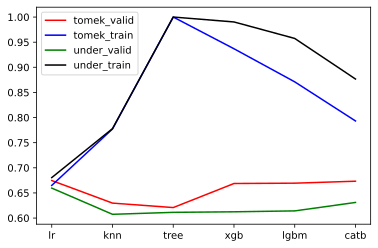

In [76]:
plt.plot(state_balance_tomek['model_name'], state_balance_tomek['f1_macro_valid-tomek'], color='r', label='tomek_valid')
plt.plot(state_balance_tomek['model_name'], state_balance_tomek['f1_macro_train-tomek'], color='b', label='tomek_train')
plt.plot(state_balance_under['model_name'], state_balance_under['f1_macro_valid-under'], color='green', label='under_valid')
plt.plot(state_balance_under['model_name'], state_balance_under['f1_macro_train-under'], color='black', label='under_train')
plt.legend()

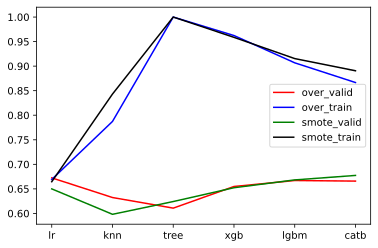

In [77]:
plt.plot(state_balance_over['model_name'], state_balance_over['f1_macro_valid-over'], color='r', label='over_valid')
plt.plot(state_balance_over['model_name'], state_balance_over['f1_macro_train-over'], color='b', label='over_train')
plt.plot(state_balance_smote['model_name'], state_balance_smote['f1_macro_valid-smote'], color='green', label='smote_valid')
plt.plot(state_balance_smote['model_name'], state_balance_smote['f1_macro_train-smote'], color='black', label='smote_train')
plt.legend()

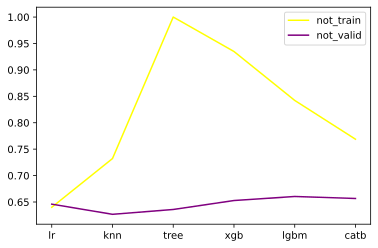

In [79]:
plt.plot(state_not_balance['model_name'], state_not_balance['f1_macro_train-not'], color='yellow', label='not_train')
plt.plot(state_not_balance['model_name'], state_not_balance['f1_macro_valid-not'], color='purple', label='not_valid')
plt.legend()

Result my search
### The best balance method is tomek
### The best classification model is CatBoost and XGBClassifier

In [15]:
df_for_balancing = pd.concat([x_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_COLUMN, method='tomek')

display(df_balanced[TARGET_COLUMN].value_counts())

x_train_bal = df_balanced.drop(columns=TARGET_COLUMN)
y_train_bal = df_balanced[TARGET_COLUMN]

0    3662
1    1585
Name: Credit Default, dtype: int64

In [24]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 7446 to 3133
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Annual Income                 5625 non-null   float32 
 1   Tax Liens                     5625 non-null   float32 
 2   Number of Open Accounts       5625 non-null   float32 
 3   Years of Credit History       5625 non-null   float32 
 4   Maximum Open Credit           5625 non-null   float32 
 5   Number of Credit Problems     5625 non-null   float32 
 6   Months since last delinquent  5625 non-null   float32 
 7   Bankruptcies                  5625 non-null   float32 
 8   Current Loan Amount           5625 non-null   float32 
 9   Current Credit Balance        5625 non-null   float32 
 10  Monthly Debt                  5625 non-null   float32 
 11  Credit Score                  5625 non-null   float32 
 12  Annual Income_outlier         5625 non-null  

In [16]:
%%time
import catboost as catb

x_train_bal[CATEGORY_COLUMNS] = x_train_bal[CATEGORY_COLUMNS].astype(np.int)
disbalance = round(y_train_bal.value_counts()[0] / y_train_bal.value_counts()[1], 2)

catb_model = catb.CatBoostClassifier(silent=True,
                                     random_state=49,
                                     cat_features=CATEGORY_COLUMNS + number_category_columns,
                                     class_weights=[1, disbalance],
                                     # eval_metric='F1',
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     reg_lambda=2.5,
                                     custom_metric=['Precision', 'Recall']
)

catb_model.fit(x_train_bal, y_train_bal, eval_set=(x_valid, y_valid))
evaluate_model(catb_model, x_train_bal, x_valid, y_train_bal, y_valid)

TRAIN
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      3662
           1       0.61      0.80      0.69      1585

    accuracy                           0.79      5247
   macro avg       0.76      0.79      0.77      5247
weighted avg       0.81      0.79      0.79      5247

VALID
              precision    recall  f1-score   support

           0       0.83      0.71      0.76      1347
           1       0.46      0.64      0.53       528

    accuracy                           0.69      1875
   macro avg       0.65      0.67      0.65      1875
weighted avg       0.73      0.69      0.70      1875

		Cross Matrix
col_0             0    1
Credit Default          
0               951  396
1               192  336
Wall time: 19.7 s


## After balancing indicators, data estimates deteriorated for model catboost

In [31]:
x_valid[CATEGORY_COLUMNS] = x_valid[CATEGORY_COLUMNS].astype(np.int)

In [17]:
def get_disbalance(target):
    value_counts_by_target = target.value_counts()
    param_argument_max = value_counts_by_target.argmax()
    param_argument_min = value_counts_by_target.argmin()
    disbalance = round(value_counts_by_target[param_argument_max] // value_counts_by_target[param_argument_min], 2)
    return disbalance

In [32]:
%%time
import xgboost as xgb

# x_train[CATEGORY_COLUMNS] = x_train[CATEGORY_COLUMNS].astype(np.int)
# x_valid[CATEGORY_COLUMNS] = x_valid[CATEGORY_COLUMNS].astype(np.int)

xgboost_model =  xgb.XGBClassifier(random_state=49,
                                   silent=True,
                                   # reg_lambda=2.5,
                                   reg_alpha=2.5,
                                   scale_pos_weight=get_disbalance(y_train_bal),
                                   # eval_metric='error',
                                   # iterations_list,
                                   max_depth=5,
                                   n_estimators=90)

xgboost_model.fit(x_train_bal, y_train_bal)
evaluate_model(xgboost_model, x_train_bal, x_valid, y_train_bal, y_valid)

[09:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3441
           1       0.91      0.96      0.93      1585

    accuracy                           0.96      5026
   macro avg       0.94      0.96      0.95      50

## After balancing the xgb model retrained even more

### I have problems with XGBClassifier overtraining and CatBoostClassifier undertraining
I want to understanding model

In [19]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_score, recall_score, f1_score

class ShowFeatureModel:

    def __init__(self, estimator, x, y, figure_figsize=(8, 5)):
        self.feature_names = x.columns
        self.feature_importances = estimator.feature_importances_
        self.y_predict_probabilities = estimator.predict_proba(x)[:, 1]
        self.estimator = estimator
        self.x_train = x
        self.y_train = y
        self.predict_with_true_labels = np.array(tuple(zip(self.y_predict_probabilities, self.y_train)))
        figure = plt.figure(figsize=figure_figsize)
        self.plt1 = figure.add_subplot(121)
        self.plt2 = figure.add_subplot(122)

    def show_feature_importance(self, get_top=None):
        feature_names = self.feature_names
        feature_importance = self.feature_importances
        feature_df = pd.DataFrame({'feature': feature_names,
                                    'importance': feature_importance}).sort_values('importance', ascending=False)

        sns.barplot(feature_df['importance'], feature_df['feature'])
        plt.xlabel('Importance')
        plt.title('Importance of features')

        if get_top is not None:
            return feature_df['feature'][:get_top].tolist()


    def show_probability_calibration_plot(self):
        y_predict_probability = self.y_predict_probabilities
        y_true_label = self.y_train

        thresholds = []
        precisions = []
        recalls = []
        f1_scores = []

        for threshold in np.linspace(.1, .9, 9):
            thresholds.append(threshold)
            precisions.append(precision_score(y_true_label, tuple(map(int, y_predict_probability > threshold))))
            recalls.append(recall_score(y_true_label, tuple(map(int, y_predict_probability > threshold))))
            f1_scores.append(f1_score(y_true_label, tuple(map(int, y_predict_probability > threshold))))

        scores_table = pd.DataFrame({
            'f1': f1_scores,
            'precision': precisions,
            'recall': recalls,
            'probability': thresholds
        }, columns=('f1', 'precision', 'recall', 'probability')).sort_values('f1', ascending=False).round(3)

        self.show_plot_calibration(thresholds, f1_scores, precisions, recalls)
        self.plot_table_metrics_probability(scores_table)
        self.show_hist_predict_probability_true_label()


    def show_plot_calibration(self, thresholds, f1_scores, precisions, recalls):
        plt1 = self.plt1
        plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
        plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
        plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
        plt1.set_ylabel('Scores')
        plt1.set_xlabel('Probability threshold')
        plt1.set_title('Probabilities threshold calibration')
        plt1.legend(bbox_to_anchor=(.25, .25))


    def plot_table_metrics_probability(self, scores_table):
        plt1 = self.plt1
        plt1.table(cellText=scores_table.values,
                   colLabels=scores_table.columns,
                   colLoc='center', cellLoc='center', loc='bottom', bbox=[0, -1.3, 1, 1])


    def show_hist_predict_probability_true_label(self):
        plt2 = self.plt2
        predict_with_true_labels = self.predict_with_true_labels

        plt2.hist(predict_with_true_labels[predict_with_true_labels[:, 1] == 0][:, 0],
                  label='Another class', color='royalblue', alpha=1)
        plt2.hist(predict_with_true_labels[predict_with_true_labels[:, 1] == 1][:, 0],
                  label='Main class', color='darkcyan', alpha=.8)
        plt2.set_ylabel('Number of examples')
        plt2.set_xlabel('Probabilities')
        plt2.set_title('Probability histogram')
        plt2.legend(bbox_to_anchor=(1, 1))


    def show_learning_curve_plot(self, cv=5, n_jobs=-1, train_size=np.linspace(.1, 1.0, 7)):
        train_sizes, train_scores, test_scores = learning_curve(self.estimator, self.x_train, self.y_train,
                                                                cv=cv, scoring='f1',
                                                                train_sizes=train_size,
                                                                n_jobs=n_jobs)

        train_scores_mean_minus_std = np.mean(train_scores, axis=1) - np.std(train_scores, axis=1)
        tran_scores_mean_plus_std = np.mean(train_scores, axis=1) + np.std(train_scores, axis=1)
        test_scores_mean_minus_std = np.mean(test_scores, axis=1) - np.std(test_scores, axis=1)
        test_scores_mean_plus_std = np.mean(test_scores, axis=1) + np.std(test_scores, axis=1)

        plt.figure(figsize=(8, 5))
        plt.fill_between(train_sizes, train_scores_mean_minus_std,
                         tran_scores_mean_plus_std, alpha=.1, color='r')
        plt.fill_between(train_sizes, test_scores_mean_minus_std,
                         test_scores_mean_plus_std, alpha=.1, color='b')
        plt.plot(train_sizes, np.mean(train_scores, axis=1), scalex='o-', color='r', label='Training score')
        plt.plot(train_sizes, np.mean(test_scores, axis=1), scalex='o-', color='b', label='Cross validation score')

        plt.title(f'Learning curves {type(self.estimator).__name__}')
        plt.xlabel('Training examples')
        plt.ylabel('Score')
        plt.legend(loc='best')
        plt.grid()

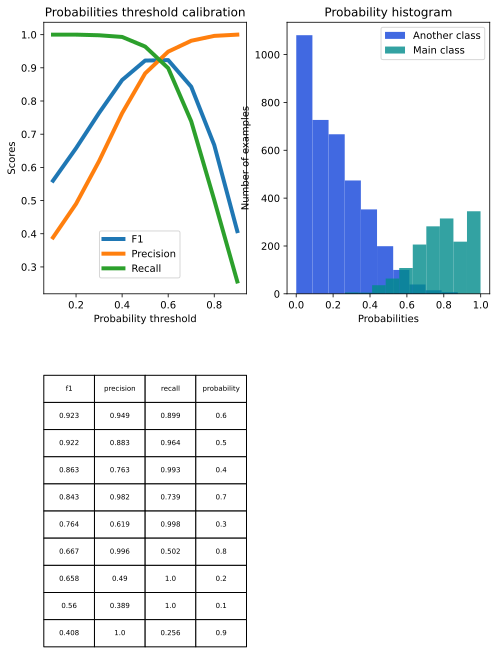

In [181]:
show_xgb = ShowFeatureModel(xgboost_model, x_train_bal, y_train_bal)
show_xgb.show_probability_calibration_plot()

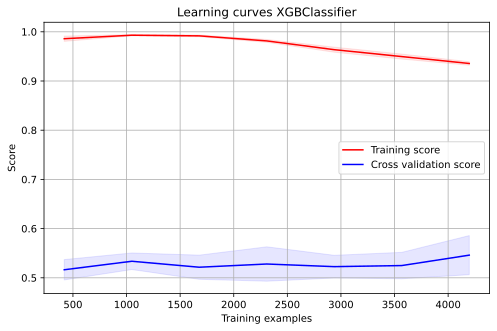

In [182]:
show_xgb.show_learning_curve_plot()

['Annual Income_outlier',
 'Credit Score_outlier',
 'Term',
 'Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Monthly Debt',
 'Home Ownership',
 'Number of Open Accounts',
 'Current Credit Balance',
 'Months since last delinquent',
 'Maximum Open Credit',
 'Years of Credit History',
 'Purpose',
 'Tax Liens']

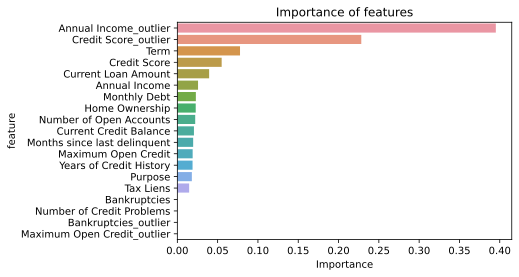

In [259]:
show_xgb.show_feature_importance(15)


Grid search for find best parameters

In [57]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

x_train[CATEGORY_COLUMNS] = x_train[CATEGORY_COLUMNS].astype(np.int)
x_valid[CATEGORY_COLUMNS] = x_valid[CATEGORY_COLUMNS].astype(np.int)

frozen_param_xgb = dict(random_state=49,
                        silent=True,
                        reg_alpha=2.5,
                        feature_names=CATEGORY_COLUMNS + number_category_columns,
                        scale_pos_weight=get_disbalance(y_train_bal))
                        # eval_metric=(x_valid, y_valid))

xgboost_model = xgb.XGBClassifier(**frozen_param_xgb)
# # max_depth=5, n_estimators=90 learning_rate=0.01

param_grid = dict(max_depth=[5, 6, 7], n_estimators=[80, 90, 100], learning_rate=[.001, 0.1, 0.2, 0.3])
k_fold = StratifiedKFold(n_splits=6, shuffle=True, random_state=49)
grid_search = GridSearchCV(xgboost_model, param_grid, scoring='neg_log_loss', cv=k_fold)
grid_result = grid_search.fit(x_train, y_train)
grid_result_model = grid_result.best_estimator_

TRAIN
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      3662
           1       0.89      0.85      0.87      1585

    accuracy                           0.92      5247
   macro avg       0.91      0.90      0.91      5247
weighted avg       0.92      0.92      0.92      5247

VALID
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1347
           1       0.53      0.49      0.51       528

    accuracy                           0.73      1875
   macro avg       0.67      0.66      0.66      1875
weighted avg       0.73      0.73      0.73      1875

		Cross Matrix
col_0              0    1
Credit Default           
0               1114  233
1                267  261


In [58]:
# summarize result

frozen_param_xgb.update(grid_result.best_params_)
print('Best %f using %r'%(grid_result.best_score_, grid_result.best_params_))
evaluate_model(grid_result_model, x_train_bal, x_valid, y_train_bal, y_valid)

Best -0.503987 using {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
TRAIN
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      3662
           1       0.89      0.85      0.87      1585

    accuracy                           0.92      5247
   macro avg       0.91      0.90      0.91      5247
weighted avg       0.92      0.92      0.92      5247

VALID
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1347
           1       0.53      0.49      0.51       528

    accuracy                           0.73      1875
   macro avg       0.67      0.66      0.66      1875
weighted avg       0.73      0.73      0.73      1875

		Cross Matrix
col_0              0    1
Credit Default           
0               1114  233
1                267  261


## Result score metrics good, but i see sign of overfitting in the model

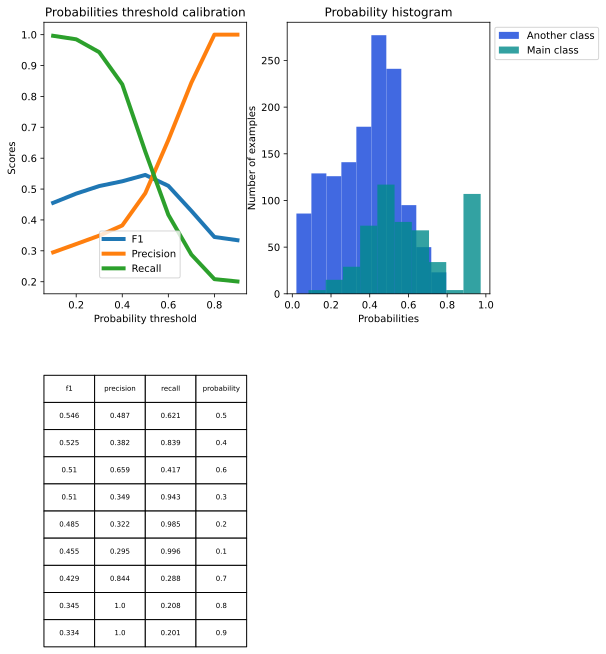

In [26]:
show_catb = ShowFeatureModel(result_model, x_valid, y_valid)
show_catb.show_probability_calibration_plot()

['Current Loan Amount',
 'Credit Score_outlier',
 'Annual Income_outlier',
 'Annual Income',
 'Credit Score',
 'Term',
 'Maximum Open Credit',
 'Home Ownership',
 'Monthly Debt',
 'Number of Open Accounts',
 'Years of Credit History',
 'Purpose',
 'Months since last delinquent',
 'Current Credit Balance']

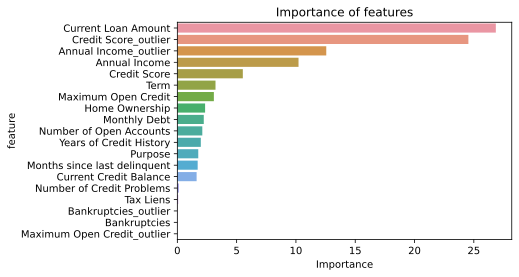

In [27]:
show_catb.show_feature_importance(14)

In [28]:
useful_params_for_catb = ['Current Loan Amount',
 'Credit Score_outlier',
 'Annual Income_outlier',
 'Annual Income',
 'Credit Score',
 'Term',
 'Maximum Open Credit',
 'Home Ownership',
 'Monthly Debt',
 'Number of Open Accounts',
 'Years of Credit History',
 'Purpose',
 'Months since last delinquent',
 'Current Credit Balance']

# I result my work

In [22]:
df_test[number_columns] = scaler.transform(df_test[number_columns])

In [33]:
category_result =list(set(CATEGORY_COLUMNS + number_category_columns).intersection(set(useful_params_for_catb)))

In [34]:

disbalance = round(y_train.value_counts()[0] / y_train.value_counts()[1], 2)

catb_model = catb.CatBoostClassifier(silent=True,
                                     random_state=49,
                                     cat_features=category_result,
                                     class_weights=[1, disbalance],
                                     # eval_metric='F1',
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     reg_lambda=2.5,
                                     custom_metric=['Precision', 'Recall'])


x_train_useful = x_train[useful_params_for_catb]
x_valid_useful = x_valid[useful_params_for_catb]

catb_model.fit(x_train_useful, y_train, eval_set=(x_valid_useful, y_valid))
evaluate_model(catb_model, x_train_useful, x_valid_useful, y_train, y_valid)

TRAIN
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      4040
           1       0.61      0.79      0.68      1585

    accuracy                           0.80      5625
   macro avg       0.76      0.79      0.77      5625
weighted avg       0.82      0.80      0.80      5625

VALID
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1347
           1       0.49      0.62      0.55       528

    accuracy                           0.71      1875
   macro avg       0.66      0.68      0.67      1875
weighted avg       0.74      0.71      0.72      1875

		Cross Matrix
col_0              0    1
Credit Default           
0               1007  340
1                201  327


In [35]:
catb_model.predict(df_test[useful_params_for_catb])

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

## I want to find the best cutoff for the cutoff probability

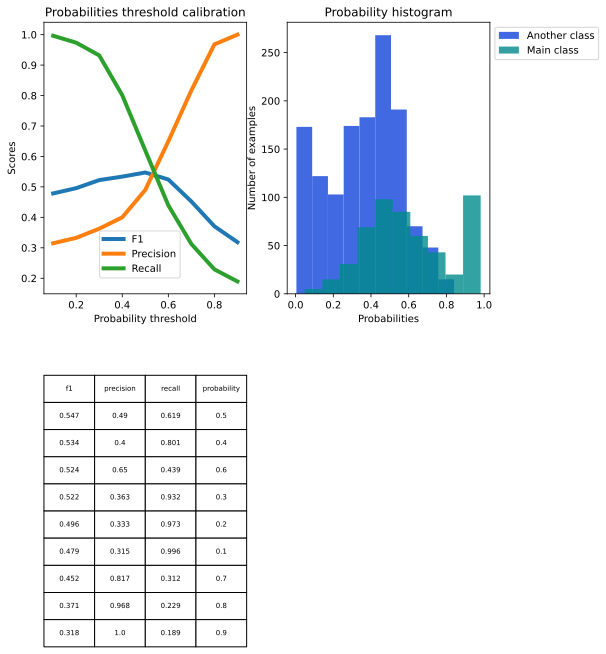

In [40]:
show_catb = ShowFeatureModel(catb_model, x_valid_useful, y_valid)
show_catb.show_probability_calibration_plot()

In [51]:
def generate_pd_for_probability(df, thresholds=.5):
    result_df = pd.DataFrame(data={'Id': df.index,
                                    'Credit Default': [int(value) if value < thresholds else 1
                                    for value in catb_model.predict_proba(df)[:, 1]]},
                            columns=['Id', 'Credit Default'])
    return result_df

result_for_valid = generate_pd_for_probability(x_valid_useful, 0.55)

print(classification_report(y_valid, result_for_valid['Credit Default']))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1347
           1       0.57      0.52      0.55       528

    accuracy                           0.76      1875
   macro avg       0.70      0.69      0.69      1875
weighted avg       0.75      0.76      0.75      1875



classification report:

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1347
           1       0.57      0.52      0.55       528

    accuracy                           0.76      1875
   macro avg       0.70      0.69      0.69      1875
weighted avg       0.75      0.76      0.75      1875


# Save result

In [53]:
predictions_df = generate_pd_for_probability(df_test[useful_params_for_catb], .55)

predictions_df['Credit Default'].value_counts()
predictions_df.to_csv('Simakov_Ya_A_predictions.csv', index=False)

with open('model_catb_classifier.pkl', 'wb') as file:
    pickle.dump(catb_model, file)
